# Статистический анализ данных

В рамках исследования популярного сервиса аренды самокатов GoFast переданы данные о некоторых пользователях из нескольких городов, а также об их поездках. нам следует проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
* без подписки
     - абонентская плата отсутствует;
     - стоимость одной минуты поездки — 8 рублей;
     - стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
     - абонентская плата — 199 рублей в месяц;
     - стоимость одной минуты поездки — 6 рублей;
     - стоимость старта — бесплатно.
     
**Цель исследования:**

1. Определить помесячную выручку по пользователям
2. Проверить четыре основные гипотезы об использовании сервиса самокатов с подпиской и без
3. Помочь оценить эффективность двух вариантов развития сервиса

**Ход исследования**

Данные о поездках, тарифах и пользователях в файлах "rides_go.csv", "subscriptions_go.csv" и "users_go.csv" соответственно. О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных

Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее, необходимое количество дополнительных таблиц, и приступлю к проведению анализа

Таким образом, моё исследование пройдёт в семь этапов:

* Обзор данных
* Предобработка данных
* Подготовка дополнительных для анализа датафреймов
* Расчет и добавление еджемесячной выручки по пользователям
* Проверка гипотез
* Исследование вариантов развития
* Оформление общего вывода по работе

_________
Перед стартом исследования зададим глобальные переменные и подключим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np 
import scipy.stats as st  #№ подключааем баблиотеку для статистический исследований
import warnings 
import matplotlib.pyplot as plt 

In [2]:
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [3]:
ALPHA = 0.05  # Устанавливаем глобальный уровень статистической значимости

## Шаг 1. Загрузка данных

### 1.1 Загружаем данные из файлов последовательно:

#### 1.1.1 Данные по поездкам:
 - **user_id**	уникальный идентификатор пользователя
 - **distance**	расстояние, которое пользователь проехал в текущей сессии (в метрах)
 - **duration**	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
 - **date**	дата совершения поездки

In [4]:
try:
    d_rides = pd.read_csv('datasets/rides_go.csv', sep=',')
    display(d_rides.head(5))
    print()
    d_rides.info()
except:
    d_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', sep=',')
    print('Файл загружен из хранилища Яндекс')
    display(d_rides.head(5))
    print()
    d_rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


**Выводы:**
- пропущенных значений нет
- тип даты поправить следует
- названия колонок вменяемые
- в части дистанции и продолжительности нужно будет провести округление и/или изменение типов

#### 1.1.2 Справочник тарифов:
 - **subscription_type**	тип подписки
 - **minute_price**	стоимость одной минуты поездки по данной подписке
 - **start_ride_price**	стоимость начала поездки
 - **subscription_fee**	стоимость ежемесячного платежа

In [5]:
try:
    d_subscriptions = pd.read_csv('datasets/subscriptions_go.csv', sep=',')
    display(d_subscriptions)
    print()
    d_subscriptions.info()
except:
    d_subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', sep=',')
    print('Файл загружен из хранилища Яндекс')
    display(d_subscriptions)
    print()
    d_subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


**Выводы:**
- пропущенных значений нет
- названия колонок вменяемые
- с типами все ОК
- дубликатов, очевидно, нет

#### 1.1.3 Справочник пользователей:

 - **user_id**	уникальный идентификатор пользователя
 - **name**	имя пользователя
 - **age**	возраст
 - **city**	город
 - **subscription_type**	тип подписки (free, ultra)

In [6]:
try:
    d_users = pd.read_csv('datasets/users_go.csv', sep=',')
    display(d_users.head(5))
    print()
    d_users.info()
except:
    d_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep=',')
    print('Файл загружен из хранилища Яндекс')
    display(d_users.head(5))
    print()
    d_users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


**Выводы:**
- пропущенных значений нет
- названия колонок вменяемые
- с типами все ОК
- могут быть явные или неявные дубликаты

## Шаг 2. Предобработка данных

### 2.1 Посмотрим на данные в таблицах с пользователями и поездками
d_subscriptions выведена полностью, там две строки, к ним вопросов нет.

#### 2.1.1 Поездки:

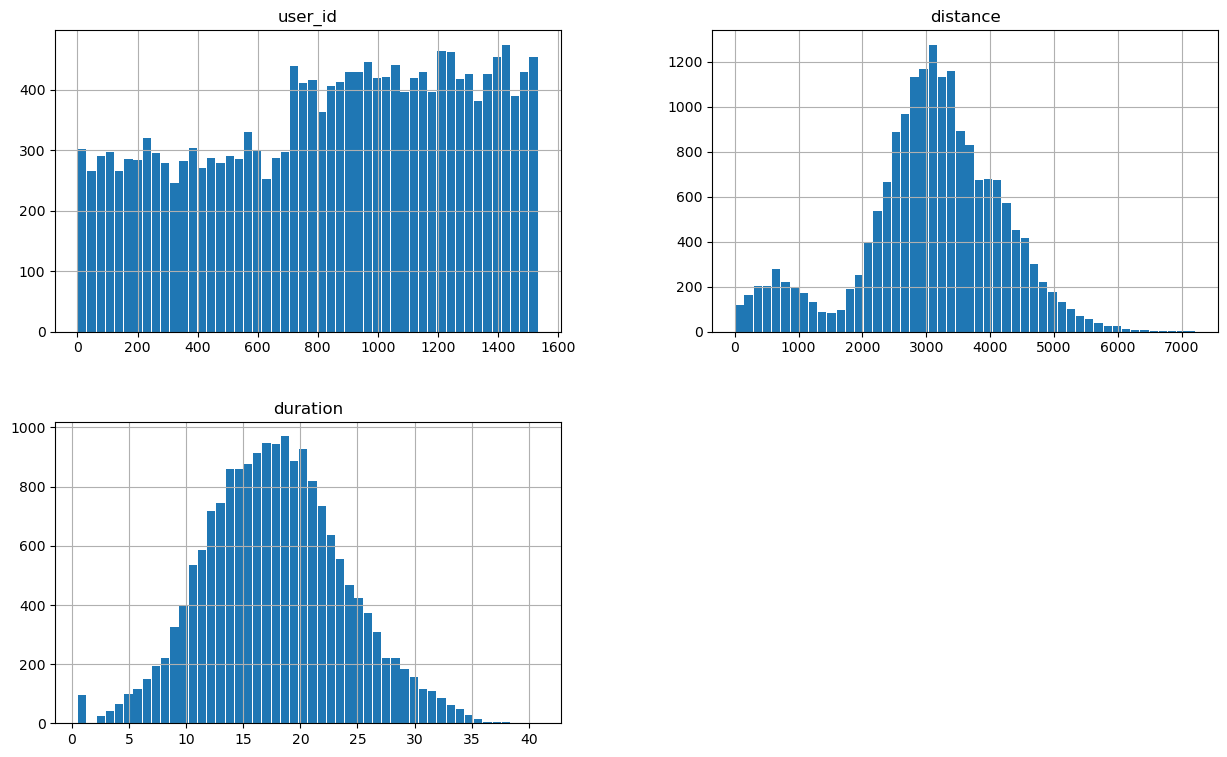

In [7]:
d_rides.hist(figsize=(15, 9), rwidth= .9, bins = 50);

Обратим внимание на всплеск в duration между 0 и 0,6 минут. Возможно, кто-то ошибочно активировал самокат, потом сразу возвращал на место.

Рассмотрим расстояния вокруг этого значения длительности:

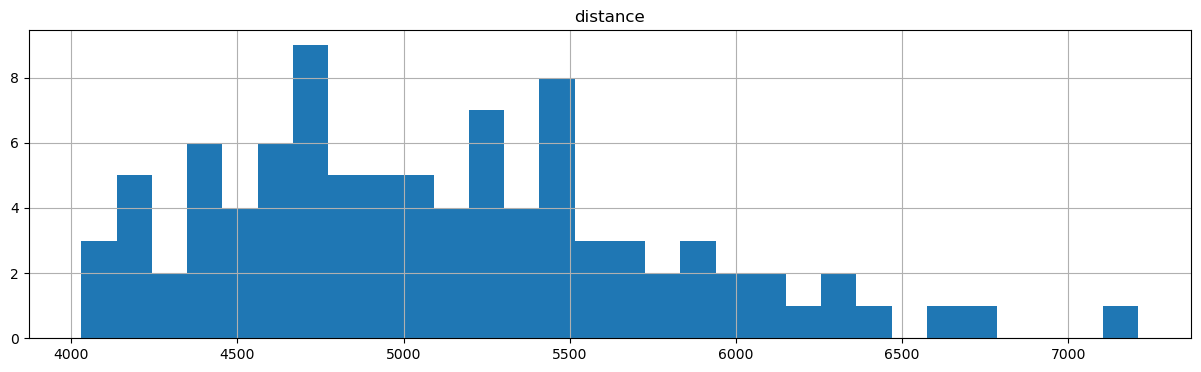

In [8]:
d_rides[d_rides['duration'] < 0.6].hist('distance', bins = 30, figsize=(15, 4));

Судя по всему, некорректные данные. Поездка от четырех до семи километров за тридцать секунд на самокате -- выглядит через чур амбициозно. Строчек с такими данными не больше сотни, дропаем их.

In [9]:
d_rides = d_rides.drop(d_rides.loc[d_rides['duration'] < 0.6, :].index)
d_rides = d_rides.reset_index()

#### 2.1.2 Пользователи:

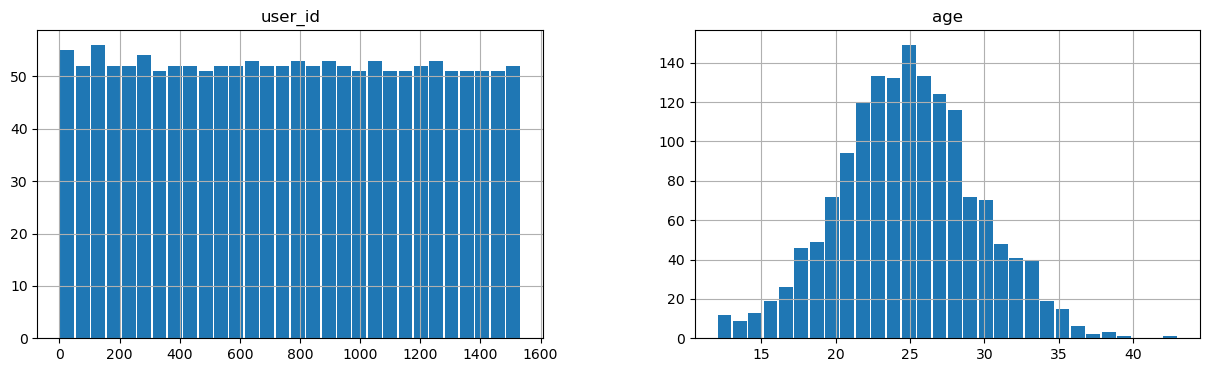

In [10]:
d_users.hist(figsize=(15, 4), rwidth= .9, bins = 30);

Похоже на правду

### 2.2 Проверим на пропущенные значения:

При первоначальном анализе (п. 1.1) по каждой из таблиц был вывод об отсутствии пустых значений.

Все заполнено, едем дальше

### 2.3 Проверим на дубликаты

#### 2.3.1 Пользователи:

In [11]:
d_users.duplicated('user_id').sum()

31

Дубли существуют, посмотрим на них:

In [12]:
d_users.loc[d_users.duplicated('user_id') == True, :]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Ничего необычного, дропаем строки

In [13]:
d_users = d_users.drop_duplicates(subset='user_id', ignore_index=False)

#### 2.3.2 Поездки:

In [14]:
d_rides.duplicated().sum()

0

Дубликаты в поездках не нашлись

### 2.4 Проверим на неявные дубликаты

Нас интересует датафрейм d_users, так как неявные дубликаты могут найтись только там

#### 2.4.1 Города

In [15]:
d_users.city.unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

#### 2.4.2 Имена

In [16]:
d_users.name.sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

Неявные дубли отсутствуют

### 2.5 Приведение типов

В пункте 2.2 "Проверим на пропущенные значения:" мы внимательно посмотрели на типы данных, предлагается:

1. d_rides.distance -> int (округлить до метра)
2. d_rides.duration - оставить float (округлить до мтера)
3. d_rides.date -> datetime

Также добавим столбец d_rides.month с номером месяца, но сначала проверим, за сколько лет выгрузка

Округляем, меняем типы:

In [17]:
# 1. d_rides.distance -> int (округлить до метра)
d_rides['distance'] = d_rides['distance'].round()
d_rides['distance'] = d_rides['distance'].astype('int')

# 2. d_rides.duration - оставить float (округлить до мтера)
d_rides['duration'] = d_rides['duration'].round(2)

# 3. d_rides.date -> datetime
d_rides.date = pd.to_datetime(d_rides.date, format='%Y-%m-%d')

Проверим, за сколько лет выгрузка

In [18]:
print(pd.DatetimeIndex(d_rides.date).year.unique())

Index([2021], dtype='int32', name='date')


Только один год -- 2021, спокойно добавляем столбец с месяцем, неприятностей не будет.

In [19]:
d_rides['month'] = pd.DatetimeIndex(d_rides.date).month

Проверим, что у нас получилось в плане типов:

In [20]:
d_rides.info()
d_rides.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     17973 non-null  int64         
 1   user_id   17973 non-null  int64         
 2   distance  17973 non-null  int32         
 3   duration  17973 non-null  float64       
 4   date      17973 non-null  datetime64[ns]
 5   month     17973 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 702.2 KB


,index,user_id,distance,duration,date,month
0,0,1,4410,25.60,2021-01-01,1
1,1,1,2618,15.82,2021-01-18,1
2,2,1,754,6.23,2021-04-20,4
3,3,1,2695,18.51,2021-08-11,8
4,4,1,4029,26.27,2021-08-28,8


Все ОК, с предобработкой можно закончить.
В ходе работ:

1. в d_rides
 - distance перевел в int (округлил до метра)
 - duration - оставил float (округлил до мтера)
 - date перевел в datetime
 - Удалил строки в duration == 0.5 (95 строк)
 
2. в d_users
 - удалил 31 строки -- полные дубликаты

## Шаг 3. Исследовательский анализ данных

### 3.1 Опишите и визуализируйте общую информацию о пользователях и поездках:

#### 3.1.1 Частота встречаемости городов

Посмотрим, как распределены пользователи и объем поездок по городам:

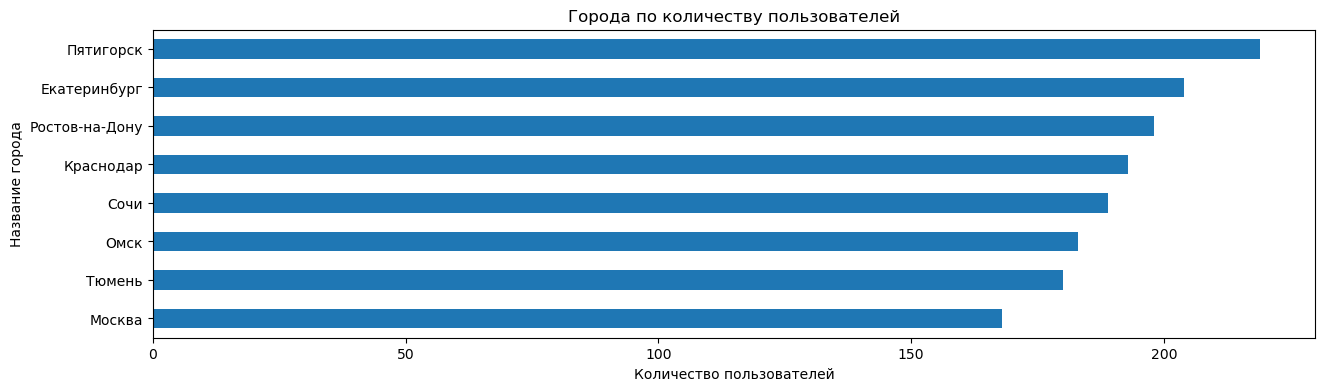

In [21]:
d_users.groupby('city')['city'].count().sort_values().plot(kind='barh', \
                                                                title='Города по количеству пользователей', \
                                                                xlabel='Количество пользователей', \
                                                                ylabel='Название города', \
                                                                figsize=(15, 4));

И пользователи, и поездки сравнительно равномерно распределены по городам в рамках выборки.
 - Больше всего пользователей в Пятигорске 204 человека
 - Меньше всего пользователей в Москве 168 человека

#### 3.1.2 Соотношение пользователей с подпиской и без подписки

Посмотрим, как рапределны пользоветели с подпиской Ultra и без подписки в рамках выборки:

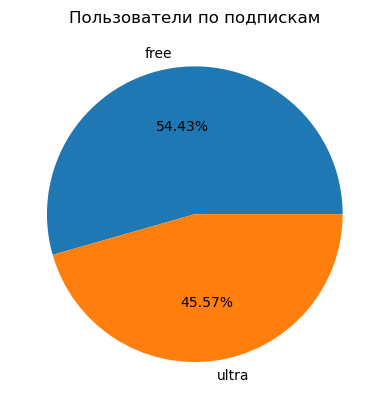

In [22]:
d_users.groupby('subscription_type')['user_id'].count().plot(kind='pie', \
                                                                  autopct=lambda p:f'{p:.2f}%', \
                                                                  title='Пользователи по подпискам', \
                                                                  ylabel='');

 - Пользователи без подписки и пользователи с Ultra распределны примерно поровну -- 54% против 46%, но все же с доминированием пользователей без подписки

_______________________
Далее у нас сравнительно однообразные по механике исследования по распределению возраста, дистанции и продолжительности.

Поэтому, определим функцию diagramm_hist_boxplot:

In [23]:
def diagramm_hist_boxplot (data_loc, series_loc, bins_loc, title_loc, x_loc, y_loc):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5)) 
    plt.subplots_adjust(wspace=0.3) 
    
    print(data_loc[series_loc].describe())
    
    axs[0].hist(data_loc[series_loc], bins=bins_loc)  # Вывожу гистограмму
    axs[0].set_title(title_loc + ' hist') 
    axs[0].set_xlabel(x_loc) 
    axs[0].set_ylabel(y_loc) 
    
    axs[1].boxplot(data_loc[series_loc])  # Вывожу boxplot
    axs[1].set_title(title_loc + ' boxplot')
    axs[1].set_ylabel(y_loc)

#### 3.1.3 Возраст пользователей

Посмотрим, как рапределен возраст пользоветелей в рамках выборки:

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


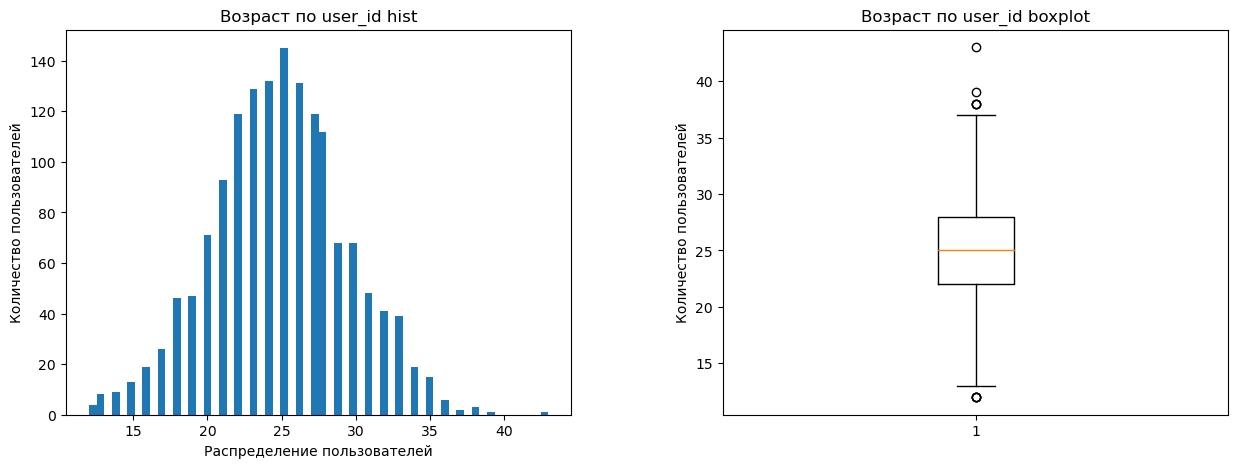

In [24]:
diagramm_hist_boxplot(d_users, 'age', 60, 'Возраст по user_id', 'Распределение пользователей', 'Количество пользователей')

Большинство пользователей сервиса в пределах 22 и 28-и лет, особых выбросов нет.

#### 3.1.4 Расстояние, которое пользователь преодолел за одну поездку

Посмотрим, как рапределено преодолеваемое расстояние в рамках выборки:

count    17973.000000
mean      3059.862905
std       1108.815513
min          1.000000
25%       2539.000000
50%       3129.000000
75%       3763.000000
max       7066.000000
Name: distance, dtype: float64


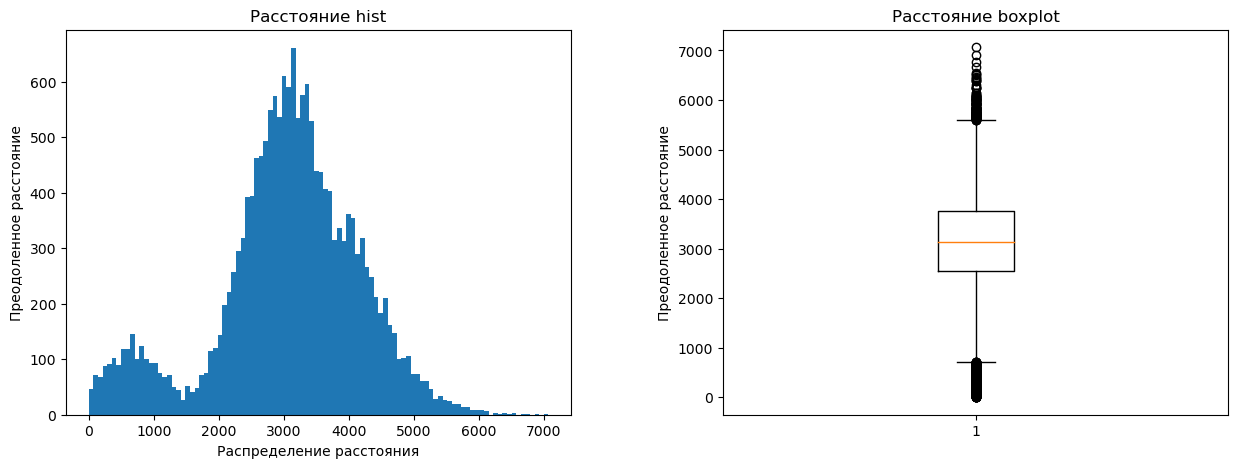

In [25]:
diagramm_hist_boxplot(d_rides, 'distance', 100, 'Расстояние', 'Распределение расстояния', 'Преодоленное расстояние')

 - Большинство поездок от 2,5км до 3.1км
 - Наблюдаем логичные выбросы до семи километров, тут вопросов особых нет -- ингода на самокате проезжаешь сравнительно внушительное расстояние, но случаи такие редки
 - Наблюдается локальный максимум до 1,5км, похоже на поездки по территории достопримечательностей -- они короче, но длительнее обычно

#### 3.1.5 Продолжительность поездок

Посмотрим, как распределена продолжительность поездок в рамках выборки:

count    17973.000000
mean        17.896486
std          5.975444
min          2.040000
25%         13.670000
50%         17.710000
75%         21.750000
max         40.820000
Name: duration, dtype: float64


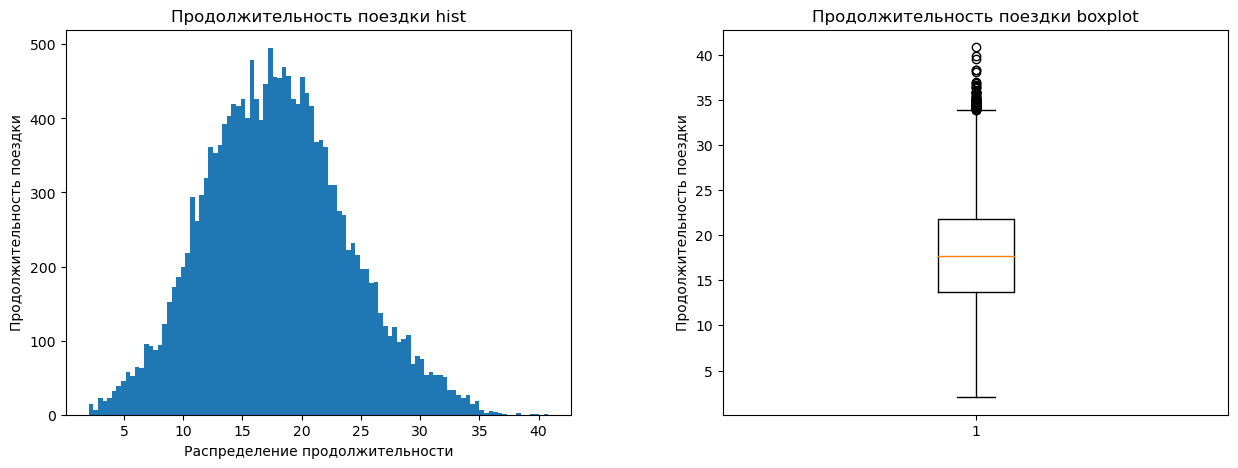

In [26]:
diagramm_hist_boxplot(d_rides, 'duration', 100, 'Продолжительность поездки', \
                      'Распределение продолжительности', 'Продолжительность поездки')

 - Большинство поездок длятся от 14 до 22-х минут
 - Существуют выбросы -- длительные поездки больше получаса, но это нормально сходится со вторым выводом по распределению расстояния

## Шаг 4. Объединение данных

### 4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм

Объединим в df датафреймы d_users, d_subscriptions и d_rides, добавим округленную до минуты (вверх) продолжиетльность поездки

In [27]:
# Объединим в df датафреймы d_users, d_subscriptions и d_rides
df = d_rides.merge(right=d_users, how='left', left_on='user_id', right_on='user_id')
df = df.merge(right=d_subscriptions, how='left', left_on='subscription_type', right_on='subscription_type')
df = df.drop(columns='index')

# Добавляем округленную до минуты (вверх) продолжиетльность поездки
df['duration_for_gain'] = np.ceil(df['duration']).astype('int')

Посмотрим на итоговую таблицу, сравним количество строк с d_rides:

In [28]:
df

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,duration_for_gain
0,1,4410,25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199,26
1,1,2618,15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199,16
2,1,754,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199,7
3,1,2695,18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199,19
4,1,4029,26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781,19.82,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0,20
17969,1534,2840,21.41,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0,22
17970,1534,3826,18.44,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0,19
17971,1534,2902,16.67,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0,17


17973 -- все сходится.

Посмотрим сразу на распределение количества поездок по подпискам:

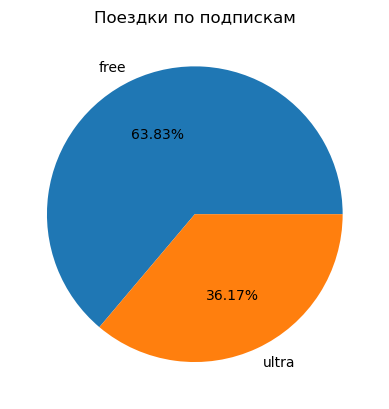

In [29]:
df.groupby('subscription_type')['user_id'].count().plot(kind='pie', \
                                                             autopct=lambda p:f'{p:.2f}%', \
                                                             title='Поездки по подпискам', \
                                                             ylabel='');

Заметим, что поездки по подпискам распределены иначе, чем пользователи, разрыв между "Без подписки" и "С Ultra" вырос -- 64% против 36% (для пользователей было 54% против 46%)

### 4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
 - c данными о пользователях без подписки (df_free)
 - с данными о пользователях с подпиской (df_ultra)

In [30]:
df_free = df.loc[df['subscription_type'] == 'free', :]
df_free.head(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,duration_for_gain
6500,700,2516,14.94,2021-01-02,1,Айдар,22,Омск,free,8,50,0,15
6501,700,847,16.23,2021-02-01,2,Айдар,22,Омск,free,8,50,0,17
6502,700,4004,20.02,2021-02-04,2,Айдар,22,Омск,free,8,50,0,21
6503,700,1206,9.78,2021-02-10,2,Айдар,22,Омск,free,8,50,0,10
6504,700,3047,17.43,2021-02-14,2,Айдар,22,Омск,free,8,50,0,18


In [31]:
df_ultra = df.loc[df['subscription_type'] == 'ultra', :]
df_ultra.head(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,duration_for_gain
0,1,4410,25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199,26
1,1,2618,15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199,16
2,1,754,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199,7
3,1,2695,18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199,19
4,1,4029,26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199,27


### 4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий
Повторим шаги 3.2.4 и 3.2.5, но для каждой части датафреймов df_free и df_ultra отдельно:

#### 4.3.1 Расстояние

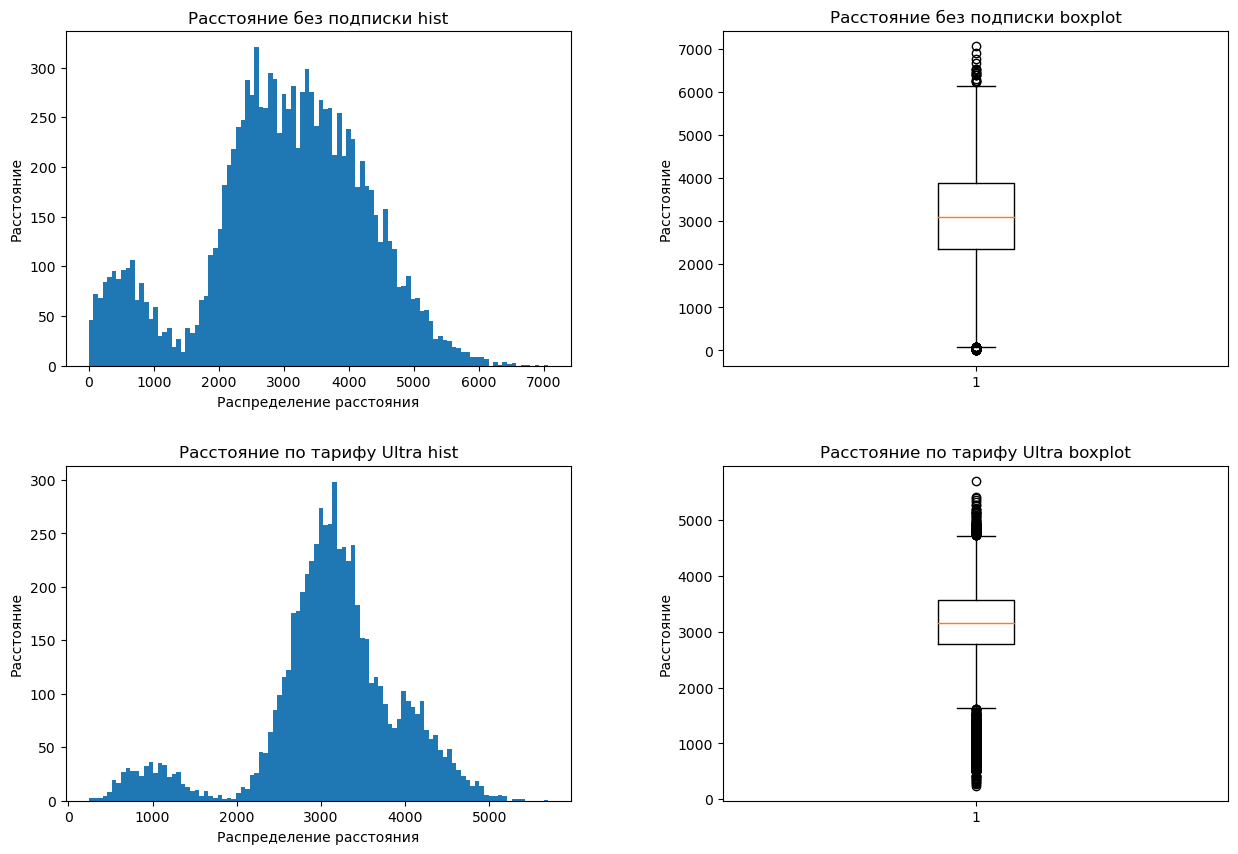

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10)) 
plt.subplots_adjust(wspace=0.3, hspace=0.3)

axs[0, 0].hist(df_free['distance'], bins=100) # Вывожу гистограмму
axs[0, 0].set_title('Расстояние без подписки' + ' hist') 
axs[0, 0].set_xlabel('Распределение расстояния') 
axs[0, 0].set_ylabel('Расстояние') 

axs[0, 1].boxplot(df_free['distance']) # Вывожу boxplot
axs[0, 1].set_title('Расстояние без подписки' + ' boxplot') 
axs[0, 1].set_ylabel('Расстояние') 

axs[1, 0].hist(df_ultra['distance'], bins=100) # Вывожу гистограмму
axs[1, 0].set_title('Расстояние по тарифу Ultra' + ' hist') 
axs[1, 0].set_xlabel('Распределение расстояния') 
axs[1, 0].set_ylabel('Расстояние') 

axs[1, 1].boxplot(df_ultra['distance']) # Вывожу boxplot
axs[1, 1].set_title('Расстояние по тарифу Ultra' + ' boxplot') 
axs[1, 1].set_ylabel('Расстояние'); 

#### 4.3.2 Продолжительность поездки

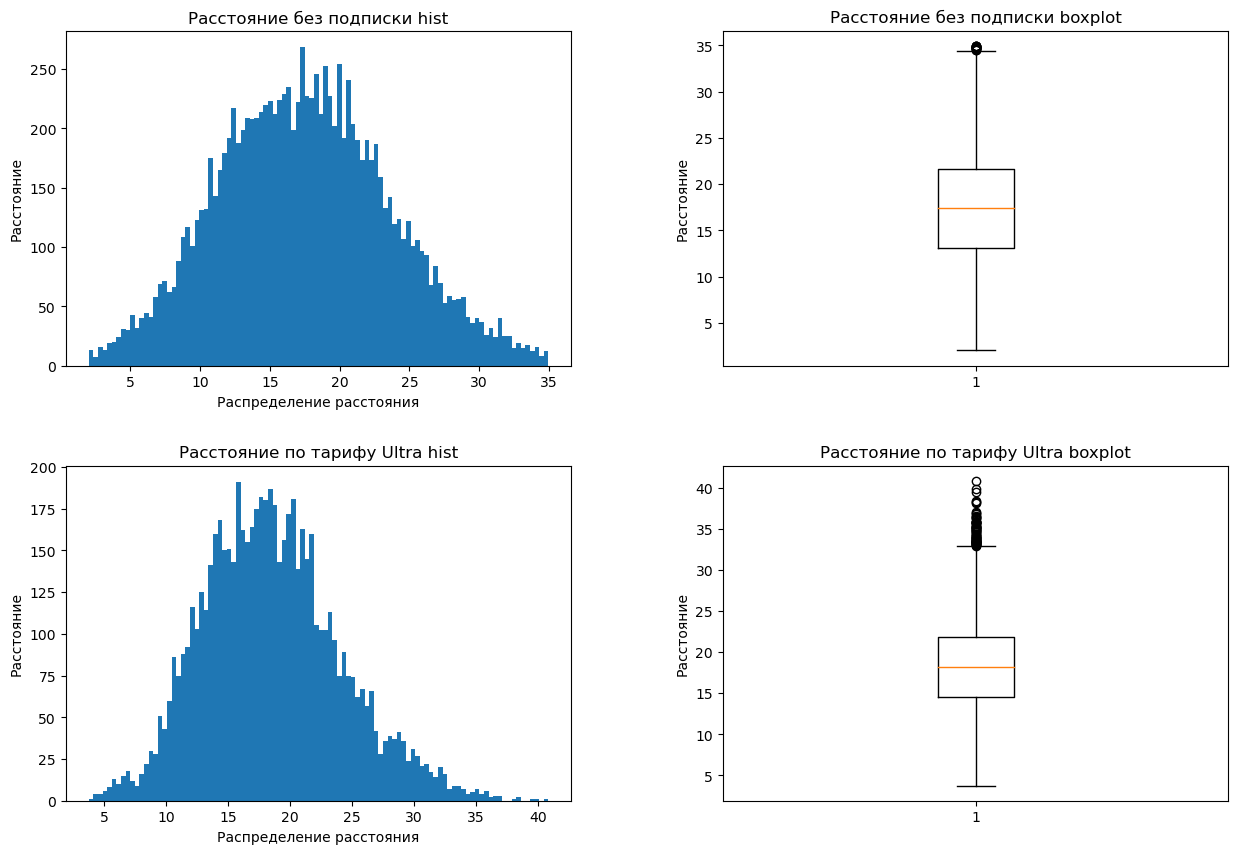

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3) 

axs[0, 0].hist(df_free['duration'], bins=100) # Вывожу гистограмму
axs[0, 0].set_title('Расстояние без подписки' + ' hist') 
axs[0, 0].set_xlabel('Распределение расстояния')
axs[0, 0].set_ylabel('Расстояние') 

axs[0, 1].boxplot(df_free['duration']) # Вывожу boxplot
axs[0, 1].set_title('Расстояние без подписки' + ' boxplot') 
axs[0, 1].set_ylabel('Расстояние')

axs[1, 0].hist(df_ultra['duration'], bins=100) # Вывожу гистограмму
axs[1, 0].set_title('Расстояние по тарифу Ultra' + ' hist') 
axs[1, 0].set_xlabel('Распределение расстояния') 
axs[1, 0].set_ylabel('Расстояние') 

axs[1, 1].boxplot(df_ultra['duration']) # Вывожу boxplot
axs[1, 1].set_title('Расстояние по тарифу Ultra' + ' boxplot') 
axs[1, 1].set_ylabel('Расстояние'); 

Основная наблюдаемая тенденция -- разброс значений и по продолжительности, и по дистанции у пользователей с подпиской меньше -- значения сильнее сфокусированы вокруг медианы  

||**free**|**Ultra**|
|----------|----------|----------|
| **distance**|1523|776|
|**duration**|8.55|7.35|


## Шаг 5. Подсчёт выручки

### 5.1 Создайте датафрейм с агрегированными данными о поездках

In [34]:
# создаем df_cost_p_m на основе сводной таблицы
df_cost_p_m = df.pivot_table(index=['user_id', 'month'], aggfunc=['sum', 'count'], values=['distance', 'duration_for_gain'])
# выравниваем названия колонок
df_cost_p_m.columns = ['sum_distance', 'sum_duration', 'count_rides', 'count']
# добавляем тариф
df_cost_p_m = df_cost_p_m.merge(right=d_users[['user_id', 'subscription_type']], \
                                how='left', left_on='user_id', right_on='user_id')
# добавляем инфу по тарифу
df_cost_p_m = df_cost_p_m.merge(right=d_subscriptions, \
                                how='left', left_on='subscription_type', right_on='subscription_type')
# кладем многомерный индекс в колонки
df_cost_p_m.reset_index(inplace=True)
# удаляем лишнее
df_cost_p_m = df_cost_p_m.drop(columns=['index', 'count'])

In [35]:
# смотрим, что получилось:
df_cost_p_m.head(10)

,user_id,sum_distance,sum_duration,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,7028,42,2,ultra,6,0,199
1,1,754,7,1,ultra,6,0,199
2,1,6724,46,2,ultra,6,0,199
3,1,5810,32,2,ultra,6,0,199
4,1,7004,56,3,ultra,6,0,199
5,1,6752,28,2,ultra,6,0,199
6,2,10188,63,3,ultra,6,0,199
7,2,6165,40,2,ultra,6,0,199
8,2,3255,14,1,ultra,6,0,199
9,2,6781,48,2,ultra,6,0,199


### 5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь

Заполняем столбик profit_p_m:

In [36]:
df_cost_p_m['profit_p_m'] = df_cost_p_m['minute_price'] * df_cost_p_m['sum_duration'] + \
df_cost_p_m['count_rides'] * df_cost_p_m['start_ride_price'] + df_cost_p_m['subscription_fee']

# смотрим, что получилось:
print('Общая выручка по выборке:', df_cost_p_m['profit_p_m'].sum(), 'рублей')
df_cost_p_m.head(10)

Общая выручка по выборке: 3872383 рублей


,user_id,sum_distance,sum_duration,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee,profit_p_m
0,1,7028,42,2,ultra,6,0,199,451
1,1,754,7,1,ultra,6,0,199,241
2,1,6724,46,2,ultra,6,0,199,475
3,1,5810,32,2,ultra,6,0,199,391
4,1,7004,56,3,ultra,6,0,199,535
5,1,6752,28,2,ultra,6,0,199,367
6,2,10188,63,3,ultra,6,0,199,577
7,2,6165,40,2,ultra,6,0,199,439
8,2,3255,14,1,ultra,6,0,199,283
9,2,6781,48,2,ultra,6,0,199,487


## Шаг 6. Проверка гипотез

### 6.1 Подписка -> больше продолжительность?

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

**Нулевая гипотеза:**

Среднее время одной поездки пользователя с подпиской и без примерно равно

**Альтернативная гипотеза:**

Среднее время одной поездки пользователя с подпиской боольше среднего времени без подписки

**Метод:**

scipy.stats.ttest_ind() -- выборки df_ultra и df_free независимы

alternative='greater'

In [37]:
results = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')
print(f'p-value: {results.pvalue}')
print(f'Средняя продолжительность по тарифу Ultra: {df_ultra.duration.mean():.2f}')
print(f'Средняя продолжительность без тарифа: {df_free.duration.mean():.2f}')

# проверяем p-value
if results.pvalue < ALPHA:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.68327274119323e-28
Средняя продолжительность по тарифу Ultra: 18.54
Средняя продолжительность без тарифа: 17.53
Отвергаем нулевую гипотезу


**Вывод:** Есть основания говорить, что пользователи с подпиской имеют большую продолжительность поездки

### 6.2 Подписка => (distance < 3130)?

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

**Нулевая гипотеза:**

Среднее расстояние одной поездки с подпиской соответствует рекомендованному 3130 метров

**Альтернативная гипотеза:**

Среднее расстояние одной поездки с подпиской превышает рекомендованное 3130 метров

**Метод:**

scipy.stats.ttest_1samp() -- проверка односторонней гипотезы

alternative='greater'

In [38]:
scooter_wear = 3130

results = st.ttest_1samp(df_ultra['distance'], scooter_wear, alternative='greater')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < ALPHA:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195649894697724
Нет оснований отвергнуть нулевую гипотезу


**Вывод:** Нет оснований говорить, что пользователи с подпиской проезжают больше рекомендованного расстояния

### 6.3 profit_p_m для ultra > profit_p_m для free?

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

**Нулевая гипотеза:**

Средняя ежемесячная выручка без подписки равна средней ежемесячной выручке для пользователей ultra

**Альтернативная гипотеза:**

Средняя ежемесячная выручка для пользователей ultra больше, чтем для пользователей без подписки

**Метод:**

scipy.stats.ttest_ind() -- выборки ultra и free независимы

alternative='greater'

Проверяем гипотезу:

In [39]:
results = st.ttest_ind(df_cost_p_m.loc[df_cost_p_m['subscription_type'] == 'ultra', 'profit_p_m'],\
                       df_cost_p_m.loc[df_cost_p_m['subscription_type'] == 'free', 'profit_p_m'], alternative='greater')

print(f'p-value: {results.pvalue}')
print('Средняя выручка по тарифу Ultra:', df_cost_p_m.loc[df_cost_p_m['subscription_type'] == 'ultra', 'profit_p_m'].mean())
print('Средняя выручка без тарифа:', df_cost_p_m.loc[df_cost_p_m['subscription_type'] == 'free', 'profit_p_m'].mean())

# проверяем p-value
if results.pvalue < ALPHA:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.957394033609321e-30
Средняя выручка по тарифу Ultra: 362.7260092653872
Средняя выручка без тарифа: 329.2664400768435
Отвергаем нулевую гипотезу


**Вывод:** Есть основания говорить, что пользователи с подпиской приносят бОльшую ежемесячную выручку

### 6.4 Обновление сервера -> снижение количества обращений?

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Нулевая гипотеза:**

Количество обращений осталось прежним

**Альтернативная гипотеза:**

Количество обращений уменьшилось

**Метод:**

scipy.stats.ttest_rel() -- **NB!** Выборку "после" следует подготовить по тем же пользователям, что и "до"

alternative='greater'

## 7. Итоги:
В ходе исследования предоставленной выборки поездок с помощью сервиса аренды самокатов GoFast:
1. Получены и загружены файл с данными о поездках, справчоник пользователей и справочник тарифов
2. Данные были предобработаны -- устранены дубликаты, устранены противоречивые значения, типы данных скорректированы
3. Исследованы атрибуты пользователей и поездок
4. Расчитана ежемесячная выручка по пользователям
5. Исследованы гипотезы, что поможет в выборе путей развития сервиса

**Основные выводы:**

1. **Рекомендации в части данных**
* **users_go**
    - Следует определить причины задвоения данных в справочнике пользователей
* **rides_go**
    - Обнаружено 95 записей с длительностью 0,5 минут, но с расстоянием от четырех километров, следует определить причину некорректных значений в колонке "duration"
        
2. **Результаты исследования:**
* **Исследования параметров выборки**
    - **Частота встречаемости городов**  
    И пользователи, и поездки сравнительно равномерно распределены по городам в рамках выборки
        + Больше всего пользователей в Пятигорске -- 204 человека
        + Меньше всего пользователей в Москве --  168 человека  
    - **Соотношение пользователей с подпиской и без подписки**  
        + Пользователи без подписки и пользователи с Ultra распределны примерно поровну -- 54% против 46%, но все же с доминированием пользователей без подписки
    - **Возраст пользователей**
        + Большинство пользователей сервиса в пределах 22 и 28-и лет, особых выбросов нет
    - **Расстояние, которое пользователь преодолел за одну поездку**
        + Большинство поездок от 2,5км до 3.1км
        + Наблюдаются логичные выбросы до семи километров, тут вопросов особых нет -- ингода на самокате проезжаешь сравнительно внушительное расстояние, но случаи такие редки
        + Наблюдается локальный максимум до 1,5км, похоже на поездки по территории достопримечательностей -- они короче, но длительнее обычно
    - **Продолжительность поездок**
        + Большинство поездок длятся от 14 до 22-х минут
        + Существуют выбросы -- длительные поездки больше получаса, но это нормально сходится со вторым выводом по распределению расстояния
        
* **Исследования параметров выборки (отдельно -- с подпиской и без)**
    - Поездки по подпискам распределены иначе, чем пользователи, разрыв между "Без подписки" и "С Ultra" вырос -- 64% против 36%
    - Основная наблюдаемая тенденция -- разброс значений и по продолжительности, и по дистанции меньше у пользователей с подпиской -- значения сильнее сфокусированы вокруг медианы:  
    
||**free**|**Ultra**|
|---|---|---|
| **distance**|1523|776|
|**duration**|8.55|7.35|
    

3. **Проверка гипотез**
* **Тратят ли пользователи с подпиской больше времени на поездки?**  
    **Вывод:** Есть основания говорить, что пользователи с подпиской имеют большую продолжительность поездки  
* **Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**  
    **Вывод:** Нет оснований говорить, что пользователи с подпиской проезжают больше рекомендованного расстояния  
* **Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**  
    **Вывод:** Есть основания говорить, что пользователи с подпиской приносят бОльшую ежемесячную выручку